In [37]:
#script to compute cross sections of density, and tends of T&S -- start with Density
import numpy as np
import time
import xarray
import glob
import gsw

%pylab inline
pylab.rcParams['figure.figsize'] = (16,8) # Large figures
pylab.rcParams['image.cmap'] = 'seismic'
dpi=200;


### axis_font = {'fontname':'Arial', 'size':'18'}    
title_font = {'fontname':'Arial', 'size':'32', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=28)
matplotlib.rc('ytick', labelsize=28)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#load the climatologies
path = '/compyfs/vene705/E3SM_simulations/20210305.v2beta3GM900.piControl.ne30pg2_EC30to60E2r2.compy/mpas-analysis/clim/mpas/avg/unmasked_EC30to60E2r2'
run = 'GM900'
path_rst = '/compyfs/vanr302/E3SM_simulations/20210305.v2beta3GM900.piControl.ne30pg2_EC30to60E2r2.compy/run/'
mev2 = xarray.open_dataset('%s/20210305.v2beta3GM900.piControl.ne30pg2_EC30to60E2r2.compy.mpaso.rst.0306-01-01_00000.nc'%path_rst)
tranRegv2 = xarray.open_dataset('/compyfs/bart765/meshfiles/EC30to60E2r2_oceanSubBasins20210315.nc')

In [38]:
#load the climatologies
path = '/compyfs/vene705/E3SM_simulations/20201124.alpha5_59_fallback.piControl.ne30pg2_r05_EC30to60E2r2-1900_ICG.compy/mpas-analysis/clim/mpas/avg/unmasked_EC30to60E2r2'
run = 'alpha5_59'
path_rst = '/compyfs/zhen797/E3SM_simulations/20201108.alpha5_55_fallback.piControl.ne30pg2_r05_EC30to60E2r2-1900_ICG.compy/run'
mev2 = xarray.open_dataset('%s/20201108.alpha5_55_fallback.piControl.ne30pg2_r05_EC30to60E2r2-1900_ICG.compy.mpaso.rst.0201-01-01_00000.nc'%path_rst)
tranRegv2 = xarray.open_dataset('/compyfs/bart765/meshfiles/EC30to60E2r2_oceanSubBasins20210315.nc')

In [3]:
#this function finds cell indices in each region defined in the file
def create_index(me,tranReg):
    nc = me.dims['nCells']
    lon = me.lonCell.values
    lat = me.latCell.values
    regMask = tranReg.regionCellMasks.values
    soInds = np.where((regMask[:,0]==1))[0]
    aoInds = np.where((regMask[:,1]==1))[0]
    naNInds = np.where((regMask[:,2]==1)&(lat>46*np.pi/180.))[0]
    naSInds = np.where((regMask[:,2]==1)&(lat<=46*np.pi/180.))[0]
    saInds = np.where((regMask[:,3]==1))[0]
    npInds = np.where((regMask[:,4]==1))[0]
    spInds = np.where((regMask[:,5]==1))[0]
    ioInds = np.where((regMask[:,6]==1))[0]
    
    #concat all inds
    allInds = [[0],[0],[0],[0],[0],[0],[0],[0]]
    allInds[0].append(naNInds)
    allInds[1].append(naSInds)
    allInds[2].append(saInds)
    allInds[3].append(ioInds)
    allInds[4].append(npInds)
    allInds[5].append(spInds)
    allInds[6].append(aoInds)
    allInds[7].append(soInds)
    for i in range(len(allInds)):
        allInds[i].pop(0)

    return allInds

label=["Southern Ocean (Atlantic)","Southern Ocean (IndoPacific)","Southern Ocean Basin","South Atlantic Basin","North Atlantic Basin","Arctic Ocean Basin","Indian Ocean Basin" ,"South Pacific Basin","North Pacific Basin"]

#this function finds cell indices in each region defined in the file
def create_index_splitSO(me,tranReg):
    nc = me.dims['nCells']
    lon = me.lonCell.values
    lat = me.latCell.values
    regMask = tranReg.regionCellMasks.values
    soaInds = np.where((regMask[:,0]==1))[0]
    soiInds = np.where((regMask[:,1]==1))[0]
    soInds = np.where((regMask[:,2]==1))[0]
    aoInds = np.where((regMask[:,3]==1))[0]
    naInds = np.where((regMask[:,4]==1))[0]#&(lat>46*np.pi/180.))[0]
    #naSInds = np.where((regMask[:,4]==1)&(lat<=46*np.pi/180.))[0]
    saInds = np.where((regMask[:,5]==1))[0]
    npInds = np.where((regMask[:,6]==1))[0]
    spInds = np.where((regMask[:,7]==1))[0]
    ioInds = np.where((regMask[:,8]==1))[0]
    
    #concat all inds
    allInds = [[0],[0],[0],[0],[0],[0],[0],[0],[0]]
    allInds[0].append(soaInds)
    allInds[1].append(soiInds)
    allInds[2].append(soInds)
    allInds[3].append(saInds)
    allInds[4].append(naInds)
    allInds[5].append(aoInds)
    allInds[6].append(ioInds)
    allInds[7].append(spInds)
    allInds[8].append(npInds)

    for i in range(len(allInds)):
        allInds[i].pop(0)

    return allInds

#in mpas the temeprature / salinity fields are defined with -1e34 where below bathymetry, 
# this makes a nicer mask for plotting
def create_mask(me):
    #create a mask
    temp = me.temperature[0,:,:].values
    inds1 = np.where(temp<-10)[0]
    inds2 = np.where(temp<-10)[1]
    mask = np.ones_like(temp)
    mask[inds1,inds2] = np.nan
    
    return mask

# this is the actual routine that makes the lat or lon averaged profile.
def plot_cross_section(fld,ds,mesh,dist,regInds,mask,dlat=0.5*np.pi/180.,dsI=None):
    #load field
    bd = mesh.refBottomDepth.values
    
    if len(ds[fld].shape)==3:
        if ds[fld].shape[-1] == len(bd)+1:
            tmp1 = ds[fld][0,:,:-1].values
        else:
            tmp1 = ds[fld][0,:,:].values
    else:
        tmp1 = ds[fld][0,:].values
    if dsI is not None:
        #anomaly requested
        tmp2 = dsI[fld][0,:,:].values
        tmp1 -= tmp2
        
    #need to have a bit to interpolate edge quantities to centers in an easy way
    nCells = mesh.dims['nCells']
    nEdge = mesh.dims['nEdges']
    area = mesh.areaCell.values
    bd = mesh.refBottomDepth.values
    if tmp1.shape[0] > nCells:
        eonc = mesh.edgesOnCell.values-1
        dc = mesh.dcEdge.values
        dv = mesh.dvEdge.values
        tmp2 = np.zeros((nCells,len(bd)))
        ne = mesh.nEdgesOnCell.values
        for i in range(nCells):
            for j in range(ne[i]):
                iEdge = eonc[i,j]
                areaE = 0.25*dc[iEdge]*dv[iEdge]
                tmp2[i,:] += areaE*tmp1[iEdge,:-1]
            tmp2[i,:] /= area[i]
        tmp1 = tmp2
                
    output = []
    latOut = []
  #  lat = mesh.latCell.values
    
    for i in range(len(regInds)):
        #print(regInds[i])
        latR = dist[regInds[i][0]]
        areaR = area[regInds[i][0]]
        latmin = latR.min()
        latmax = latR.max()
        latV = np.arange(latmin+dlat/2,latmax,dlat)
        nlat = len(latV)
        if len(tmp1.shape)==2:
            outT = np.zeros((nlat,tmp1.shape[1]))
        else:
            outT = np.zeros(nlat)
        areaS = np.zeros(nlat)
        latOut.append(latV)
        binInds = []
        for j in range(nlat):
            binInds.append([0])
        for j in range(len(regInds[i][0])):
            spot = abs(latV-latR[j]).argmin()
            binInds[spot].append(regInds[i][0][j])
        for j in range(nlat):
            binInds[j].pop(0)
            if len(tmp1.shape)==2:
            #    print(i,mask[binInds[j],:].shape,area[binInds[j]].shape)
                outT[j,:] = np.nansum(mask[binInds[j],:]*tmp1[binInds[j],:]*area[binInds[j],np.newaxis],axis=0)/ \
                            np.nansum(mask[binInds[j],:]*area[binInds[j],np.newaxis],axis=0)
            else:
                outT[j] = np.nansum(mask[binInds[j],0]*tmp1[binInds[j]]*area[binInds[j]])/ \
                          np.nansum(mask[binInds[j],0]*area[binInds[j]])
        output.append(outT)
       
    return output,latOut


In [39]:
#this is for the new mesh
indsv2 = create_index_splitSO(mev2,tranRegv2)
maskv2 = create_mask(mev2)

In [40]:
#if you are averaging in latitude set to true.
Lon = False
if Lon:
    dist1 = mev2.lonCell.values
    #dist2 = me6030.lonCell.values
else:
    dist1 = mev2.latCell.values
    #dist2 = me6030.latCell.values

In [6]:
# transform sigma0 into sigma2
def calculate_sigma2(dsv2y1,mev2,dist1,indsv2,maskv2):
    soutv2y1,latsv2=plot_cross_section('timeMonthly_avg_activeTracers_salinity',dsv2y1,mev2,dist1,indsv2,maskv2)
    toutv2y1,latsv2=plot_cross_section('timeMonthly_avg_activeTracers_temperature',dsv2y1,mev2,dist1,indsv2,maskv2)
    sigma2=toutv2y1
    for sp in np.arange(len(soutv2y1)): 
        lat = latsv2[sp]
        z = -mev2.refBottomDepth.values
        SP = soutv2y1[sp]
        pt = toutv2y1[sp]
        #p = gsw.p_from_z(z,lat[:])
        p = gsw.p_from_z(np.tile(z, (len(lat),1)).T, lat)
        SA = gsw.SA_from_SP(SP.T,p,-25.,lat)
        CT = gsw.CT_from_pt(SA.T, pt)
        sigma2[sp] = gsw.sigma2(SA.T, CT)
    return sigma2

In [7]:
flist = '%s/mpaso_ANN_000101_000512_climo.nc'%path
dsv2 = xarray.open_dataset(flist)
sigma2=calculate_sigma2(dsv2,mev2,dist1,indsv2,maskv2)

/share/apps/E3SM/conda_envs/base/envs/e3sm_unified_1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


In [8]:
temp_clim1,latsv2=plot_cross_section('timeMonthly_avg_activeTracers_temperature',xarray.open_dataset(flist),mev2,dist1,indsv2,maskv2)

/share/apps/E3SM/conda_envs/base/envs/e3sm_unified_1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


In [9]:
Cessival=[30,32, 35, 36, 36.5, 36.8, 37,37.25, 37.44, 37.52, 37.6]

In [41]:
flist = '%s/mpaso_ANN_000101_000512_climo.nc'%path
dsv2 = xarray.open_dataset(flist)
sigma2y1=calculate_sigma2(dsv2,mev2,dist1,indsv2,maskv2)
flist = '%s/mpaso_ANN_002101_004012_climo.nc'%path
dsv2 = xarray.open_dataset(flist)
sigma2y21=calculate_sigma2(dsv2,mev2,dist1,indsv2,maskv2)
flist = '%s/mpaso_ANN_011101_013012_climo.nc'%path
dsv2 = xarray.open_dataset(flist)
sigma2y111=calculate_sigma2(dsv2,mev2,dist1,indsv2,maskv2)

/share/apps/E3SM/conda_envs/base/envs/e3sm_unified_1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


In [43]:
print(flist)


/compyfs/vene705/E3SM_simulations/20201124.alpha5_59_fallback.piControl.ne30pg2_r05_EC30to60E2r2-1900_ICG.compy/mpas-analysis/clim/mpas/avg/unmasked_EC30to60E2r2/mpaso_ANN_011101_013012_climo.nc


In [33]:
glob.glob('%s/mpaso_%s_0111??_0130??_climo.nc'%(path, season))

['/compyfs/vene705/E3SM_simulations/20210305.v2beta3GM900.piControl.ne30pg2_EC30to60E2r2.compy/mpas-analysis/clim/mpas/avg/unmasked_EC30to60E2r2/mpaso_ANN_011101_013012_climo.nc']

In [45]:
for season in ['ANN', 'JFM', 'JAS']:#'AMJ', 'JAS', 'OND']:
    flist = glob.glob('%s/mpaso_%s_0001??_0005??_climo.nc'%(path, season))[0]
    dsv2 = xarray.open_dataset(flist)
    sigma2y1=calculate_sigma2(dsv2,mev2,dist1,indsv2,maskv2)
    flist = glob.glob('%s/mpaso_%s_0021??_0040??_climo.nc'%(path, season))[0]
    dsv2 = xarray.open_dataset(flist)
    sigma2y21=calculate_sigma2(dsv2,mev2,dist1,indsv2,maskv2)
    flist = glob.glob('%s/mpaso_%s_0111??_0130??_climo.nc'%(path, season))[0]
    dsv2 = xarray.open_dataset(flist)
    sigma2y111=calculate_sigma2(dsv2,mev2,dist1,indsv2,maskv2)
    
    plot_diff_Atlantic(season, '21vs1', sigma2y21, sigma2y1)
    plot_diff_Atlantic_deep4(season, '21vs1', sigma2y21, sigma2y1)
    plot_diff_Atlantic(season, '111vs1', sigma2y111, sigma2y1)
    plot_diff_Atlantic_deep4(season, '111vs1', sigma2y111, sigma2y1)
    plot_diff_Atlantic(season, '111vs21', sigma2y111, sigma2y21)
    plot_diff_Atlantic_deep4(season, '111vs21', sigma2y111, sigma2y21)

/share/apps/E3SM/conda_envs/base/envs/e3sm_unified_1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin
0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin
0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin
0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin
0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin
0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin
0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin
0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin
0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin
0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin
0 Southern Ocean (Atlantic)
3 South Atlantic Basin

In [35]:
def plot_diff_Atlantic(season, tag, sigma2y21, sigma2y1):
    namebase = './%s/%s_DSigma2_%s_%s_'%(run, run, season, tag)
    reg = [0, 3,4,5]
    fig, ax= plt.subplots(1,4, figsize=(30,5))
    for ii in np.arange(0,4):
        sp= reg[ii]
        print(sp, label[sp])
        ax[ii].contourf(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y21[sp]-sigma2y1[sp]).T,np.linspace(-.5,.5),extend='both',cmap='RdBu_r')
        #plt.colorbar()
        CS=ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y21[sp]).T, Cessival, colors='k')
        ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y1[sp]).T, Cessival, colors='k',linestyles='dashed')
        plt.clabel(CS)
        ax[ii].set_title(label[sp],fontsize=32)
        ax[ii].set_ylim(-1200,0)
        if sp == 5: 
            ax[ii].set_ylim(-400,0)
        if Lon:
            plt.xlim(300,360)
    for ax1 in ax.flat:
        ax1.label_outer()
    ax[-1].yaxis.set_label_position("right")
    ax[-1].yaxis.tick_right()
    fig.tight_layout(pad=0.5)
    plt.savefig(namebase +'Atlantic.png')
    plt.close(fig)

In [36]:
def plot_diff_Atlantic_deep4(season, tag, sigma2y21, sigma2y1):
    namebase = './%s/%s_DSigma2_%s_%s_'%(run, run, season, tag)
    reg = [0, 3,4,5]
    fig, ax= plt.subplots(1,4, figsize=(30,5))
    for ii in np.arange(0,4):
        sp= reg[ii]
        print(sp, label[sp])
        ax[ii].contourf(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y21[sp]-sigma2y1[sp]).T,np.linspace(-.5,.5),extend='both',cmap='RdBu_r')
        #plt.colorbar()
        CS=ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y21[sp]).T, Cessival, colors='k')
        ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y1[sp]).T, Cessival, colors='k',linestyles='dashed')
        plt.clabel(CS)
        ax[ii].set_title(label[sp],fontsize=32)
        ax[ii].set_ylim(-5500,0)
        #if sp == 5: 
        #    ax[ii].set_ylim(-400,0)
        if Lon:
            plt.xlim(300,360)
    for ax1 in ax.flat:
        ax1.label_outer()
    ax[-1].yaxis.set_label_position("right")
    ax[-1].yaxis.tick_right()
    fig.tight_layout(pad=0.5)
    plt.savefig(namebase +'deep4_Atlantic.png')
    plt.close(fig)

0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin


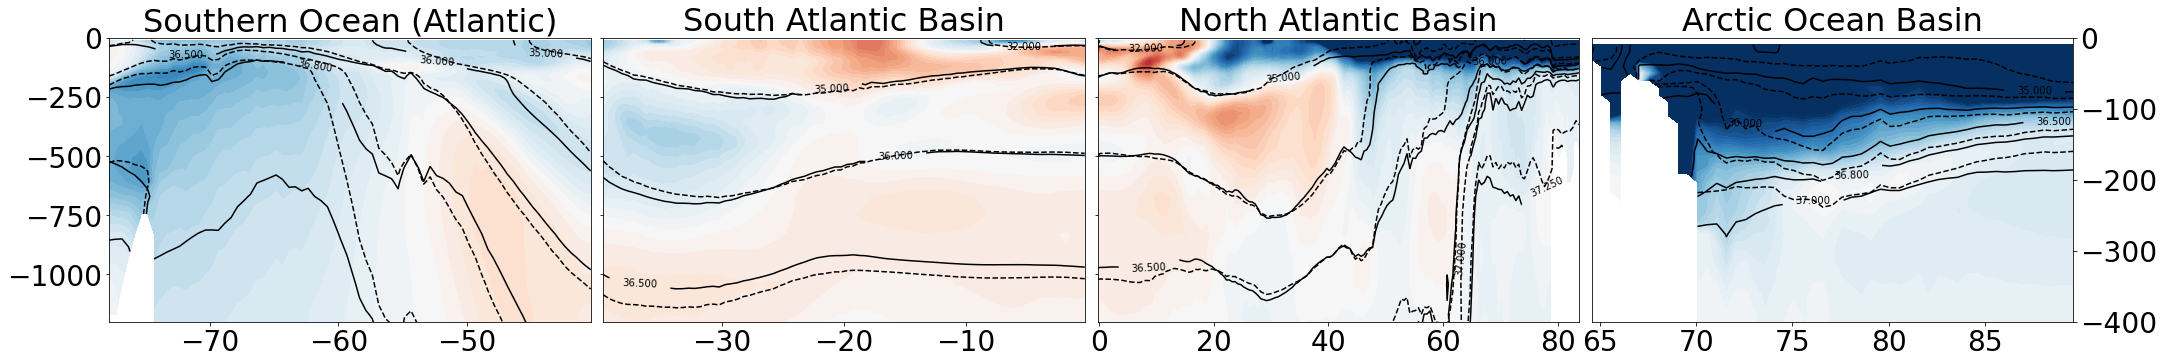

In [19]:
#reg= [-1, 2,1,0,6]
namebase = './%s/%s_DSigma2_ANN_21vs1_'%(run, run)
reg = [0, 3,4,5]
fig, ax= plt.subplots(1,4, figsize=(30,5))
for ii in np.arange(0,4):
    sp= reg[ii]
    print(sp, label[sp])
    ax[ii].contourf(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y21[sp]-sigma2y1[sp]).T,np.linspace(-.5,.5),extend='both',cmap='RdBu_r')
    #plt.colorbar()
    CS=ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y21[sp]).T, Cessival, colors='k')
    ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y1[sp]).T, Cessival, colors='k',linestyles='dashed')
    plt.clabel(CS)
    ax[ii].set_title(label[sp],fontsize=32)
    ax[ii].set_ylim(-1200,0)
    if sp == 5: 
        ax[ii].set_ylim(-400,0)
    if Lon:
        plt.xlim(300,360)
for ax1 in ax.flat:
    ax1.label_outer()
ax[-1].yaxis.set_label_position("right")
ax[-1].yaxis.tick_right()
fig.tight_layout(pad=0.5)
plt.savefig(namebase +'Atlantic.png')

0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin


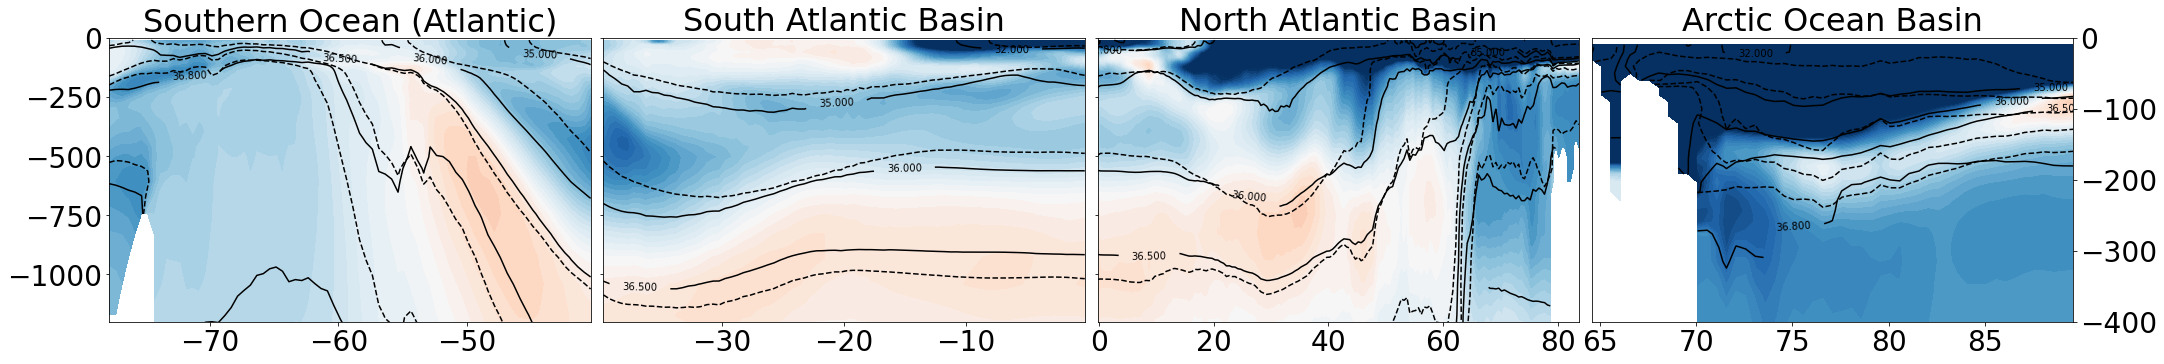

In [21]:
#reg= [-1, 2,1,0,6]
namebase = './%s/%s_DSigma2_ANN_111vs1_'%(run, run)
reg = [0, 3,4,5]
fig, ax= plt.subplots(1,4, figsize=(30,5))
for ii in np.arange(0,4):
    sp= reg[ii]
    print(sp, label[sp])
    ax[ii].contourf(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y111[sp]-sigma2y1[sp]).T,np.linspace(-.5,.5),extend='both',cmap='RdBu_r')
    #plt.colorbar()
    CS=ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y111[sp]).T, Cessival, colors='k')
    ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y1[sp]).T, Cessival, colors='k',linestyles='dashed')
    plt.clabel(CS)
    ax[ii].set_title(label[sp],fontsize=32)
    ax[ii].set_ylim(-1200,0)
    if sp == 5: 
        ax[ii].set_ylim(-400,0)
    if Lon:
        plt.xlim(300,360)
for ax1 in ax.flat:
    ax1.label_outer()
ax[-1].yaxis.set_label_position("right")
ax[-1].yaxis.tick_right()
fig.tight_layout(pad=0.5)
plt.savefig(namebase +'Atlantic.png')

0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin


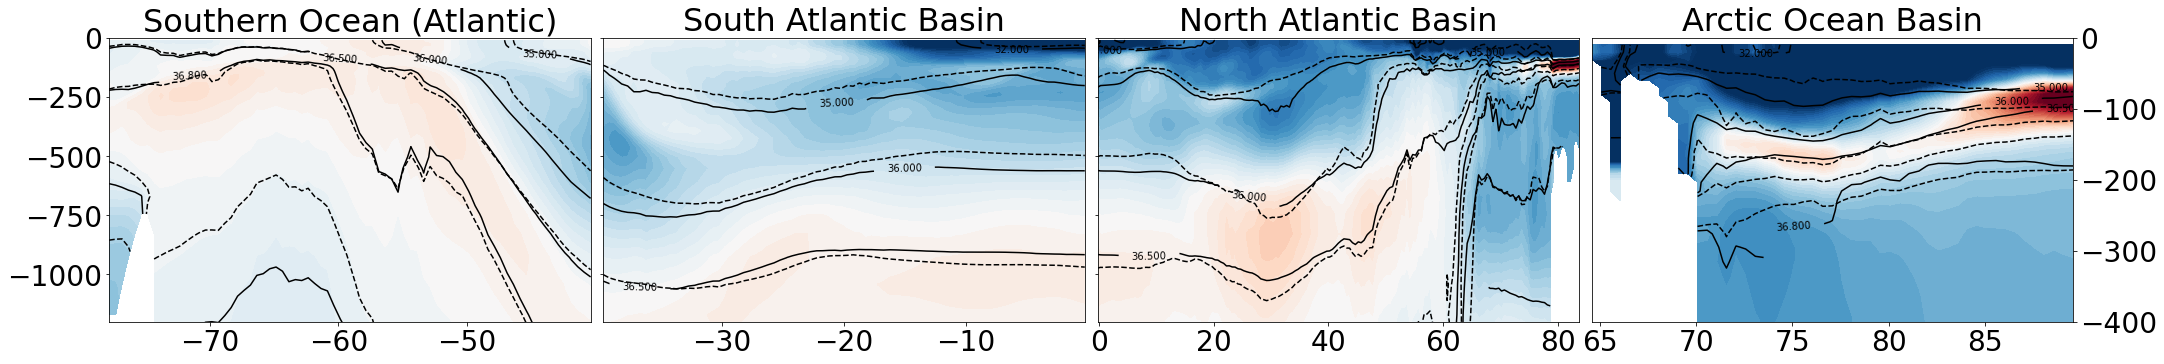

In [22]:
#reg= [-1, 2,1,0,6]
namebase = './%s/%s_DSigma2_ANN_111vs21_'%(run, run)
reg = [0, 3,4,5]
fig, ax= plt.subplots(1,4, figsize=(30,5))
for ii in np.arange(0,4):
    sp= reg[ii]
    print(sp, label[sp])
    ax[ii].contourf(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y111[sp]-sigma2y21[sp]).T,np.linspace(-.5,.5),extend='both',cmap='RdBu_r')
    #plt.colorbar()
    CS=ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y111[sp]).T, Cessival, colors='k')
    ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y21[sp]).T, Cessival, colors='k',linestyles='dashed')
    plt.clabel(CS)
    ax[ii].set_title(label[sp],fontsize=32)
    ax[ii].set_ylim(-1200,0)
    if sp == 5: 
        ax[ii].set_ylim(-400,0)
    if Lon:
        plt.xlim(300,360)
for ax1 in ax.flat:
    ax1.label_outer()
ax[-1].yaxis.set_label_position("right")
ax[-1].yaxis.tick_right()
fig.tight_layout(pad=0.5)
plt.savefig(namebase +'Atlantic.png')

0 Southern Ocean (Atlantic)
3 South Atlantic Basin
4 North Atlantic Basin
5 Arctic Ocean Basin


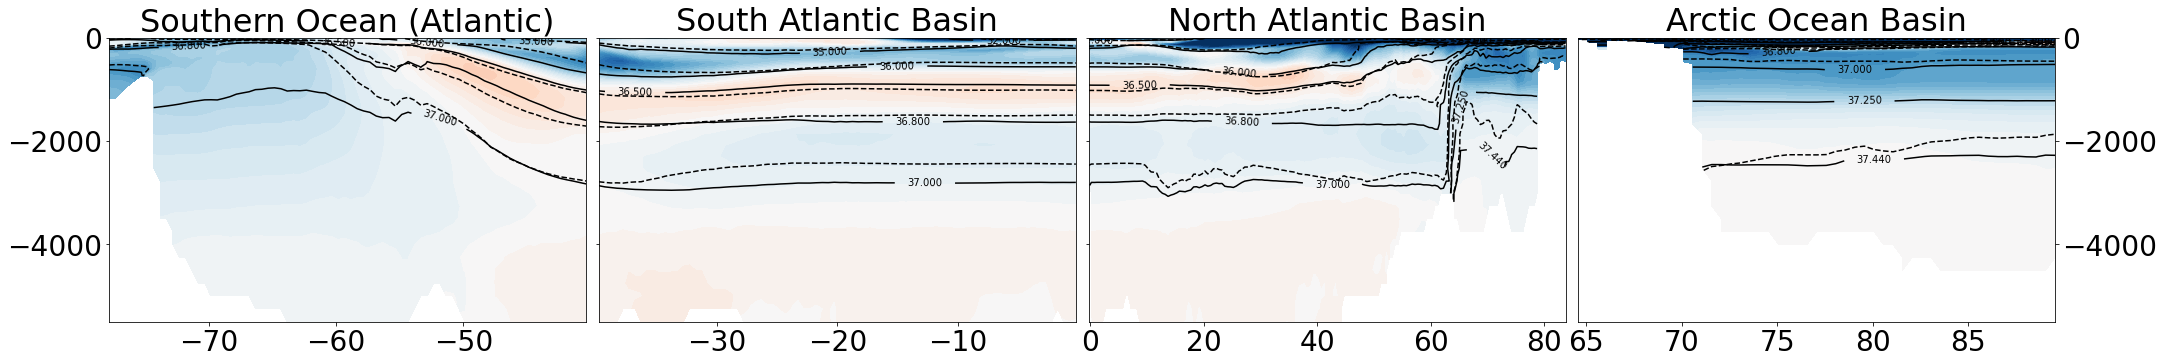

In [23]:
#reg= [-1, 2,1,0,6]
namebase = './%s/%s_DSigma2_ANN_111vs1_'%(run, run)
reg = [0, 3,4,5]
fig, ax= plt.subplots(1,4, figsize=(30,5))
for ii in np.arange(0,4):
    sp= reg[ii]
    print(sp, label[sp])
    ax[ii].contourf(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y111[sp]-sigma2y1[sp]).T,np.linspace(-.5,.5),extend='both',cmap='RdBu_r')
    #plt.colorbar()
    CS=ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y111[sp]).T, Cessival, colors='k')
    ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2y1[sp]).T, Cessival, colors='k',linestyles='dashed')
    plt.clabel(CS)
    ax[ii].set_title(label[sp],fontsize=32)
    ax[ii].set_ylim(-5500,0)
    #if sp == 5: 
    #    ax[ii].set_ylim(-400,0)
    if Lon:
        plt.xlim(300,360)
for ax1 in ax.flat:
    ax1.label_outer()
ax[-1].yaxis.set_label_position("right")
ax[-1].yaxis.tick_right()
fig.tight_layout(pad=0.5)
plt.savefig(namebase +'deep4_Atlantic.png')

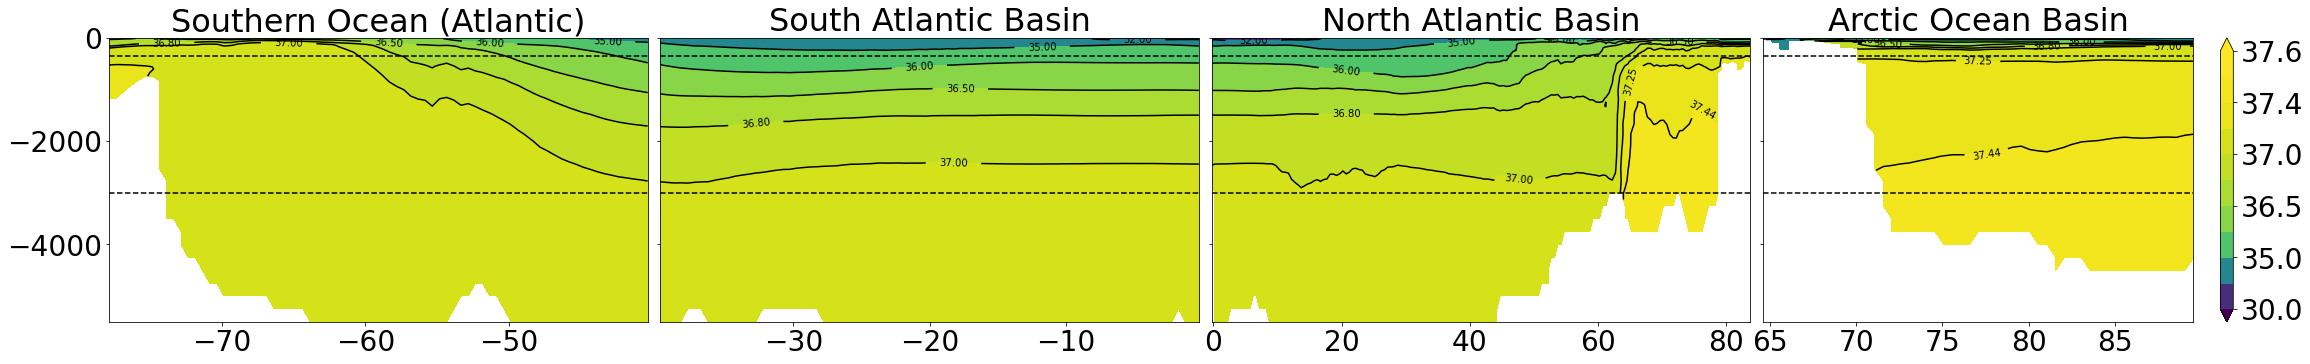

In [20]:
namebase = './%s/%s_Sigma2_ANN_000101_000512'%(run, run)
reg= reg = [0, 3,4,5]
fig, ax= plt.subplots(1,4, figsize=(32,5))
for ii in np.arange(0,4):
    sp= reg[ii]

    CF=ax[ii].contourf(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2[sp]).T,Cessival,extend='both',cmap='viridis')
    #plt.colorbar()
    CS=ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2[sp]).T,Cessival,colors='k')
    ax[ii].axhline(-350,0, 1, linestyle='--', c='k')
    ax[ii].axhline(-3000,0, 1, linestyle='--', c='k')
    #ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(potdv2[sp]).T,np.linspace(1026.,1030.,11),colors='k',linestyles='dashed')
    plt.clabel(CS,fmt='%1.2f')
    ax[ii].set_title(label[sp],fontsize=32)
    ax[ii].set_ylim(-5500,0)
    #if sp == 6: 
    #    ax[ii].set_ylim(-400,0)
    if Lon:
        plt.xlim(300,360)
for ax1 in ax.flat:
    ax1.label_outer()
#ax[-1].yaxis.set_label_position("right")
#ax[-1].yaxis.tick_right()
fig.tight_layout(pad=0.5)
plt.colorbar(CF,format='%1.1f')
plt.savefig(namebase +'deep4_Atlantic.png')

In [37]:
climfiles = sorted(glob.glob(path +'/' + 'mpaso_???_0*_climo.nc'))
climlist = [None]*len(climfiles)

In [38]:
for ii in np.arange(0,len(climfiles)):
    climlist[ii]= ('_'.join(climfiles[ii].split('/')[-1].split('_')[-4:-1]))
    #

In [45]:
clim[10:15]

'_0001'

working on clim:  AMJ_000104_000506


/share/apps/E3SM/conda_envs/base/envs/e3sm_unified_1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


working on clim:  AMJ_002104_004006
working on clim:  AMJ_011104_013006
working on clim:  ANN_000101_000512
working on clim:  ANN_002101_004012
working on clim:  ANN_011101_013012
working on clim:  JAS_000107_000509
working on clim:  JAS_002107_004009
working on clim:  JAS_011107_013009
working on clim:  JFM_000101_000503
working on clim:  JFM_002101_004003
working on clim:  JFM_011101_013003
working on clim:  OND_000110_000512
working on clim:  OND_002110_004012
working on clim:  OND_011110_013012


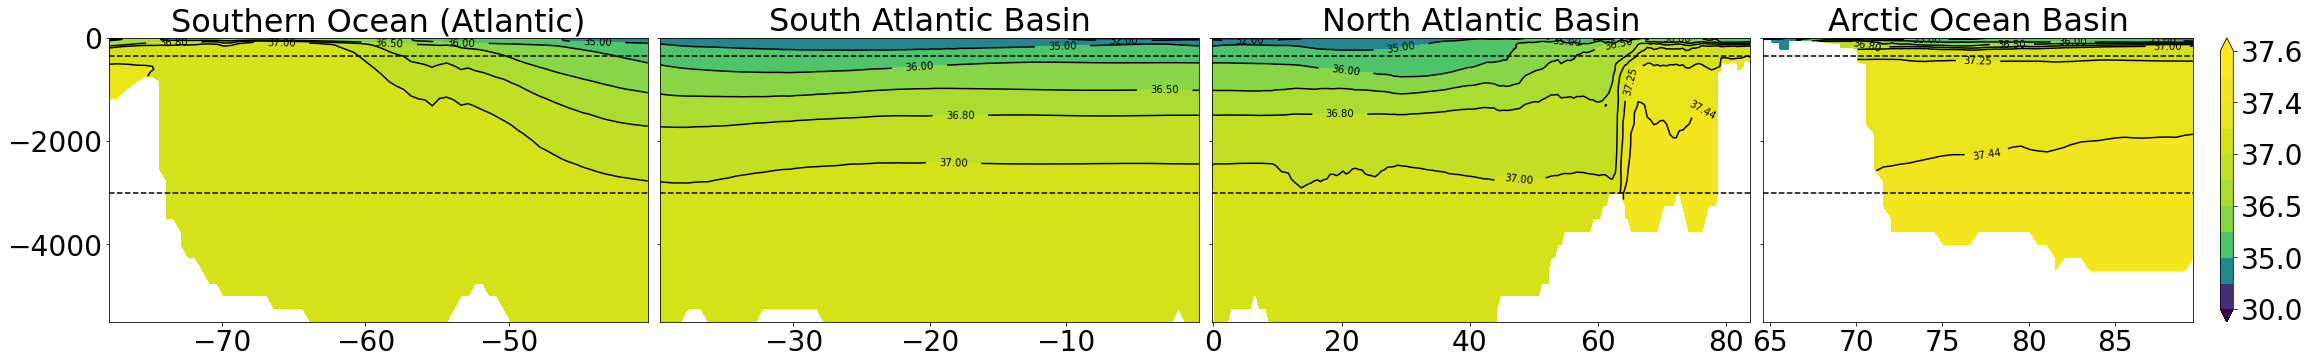

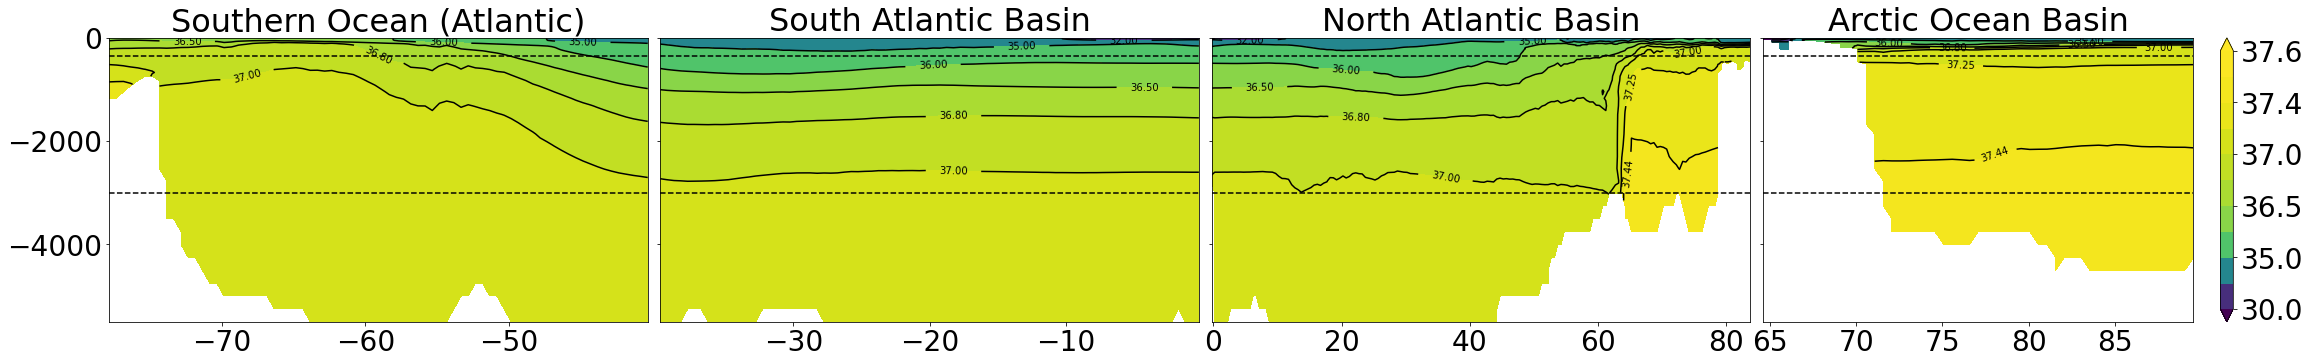

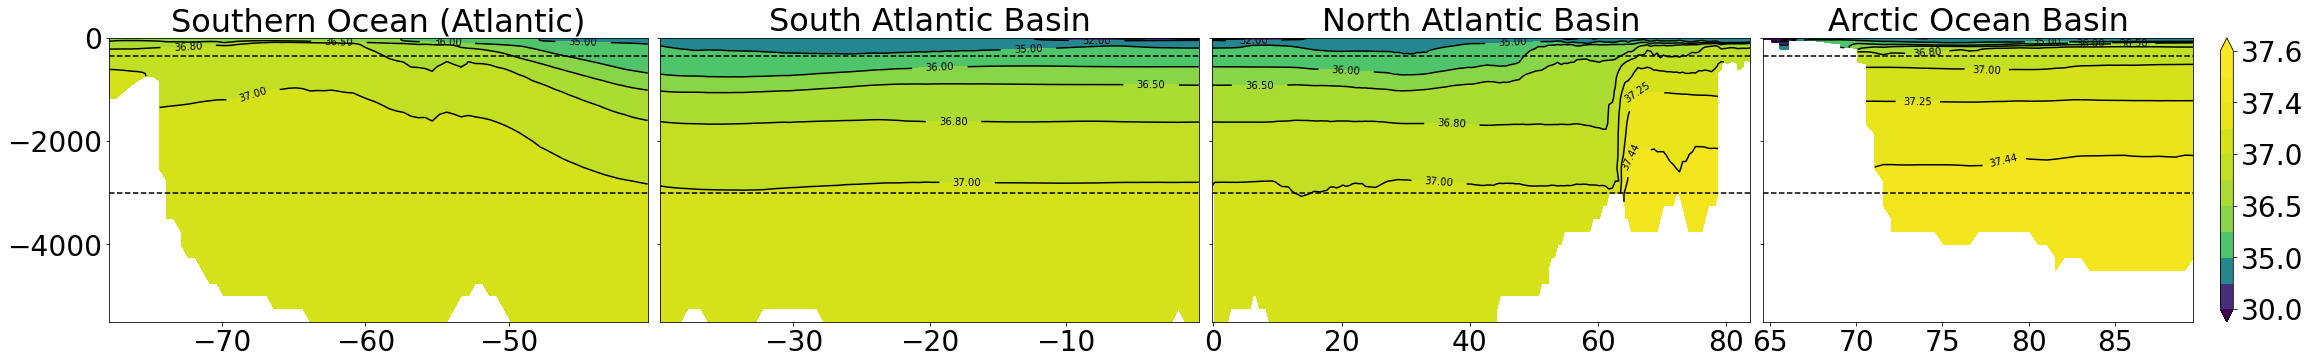

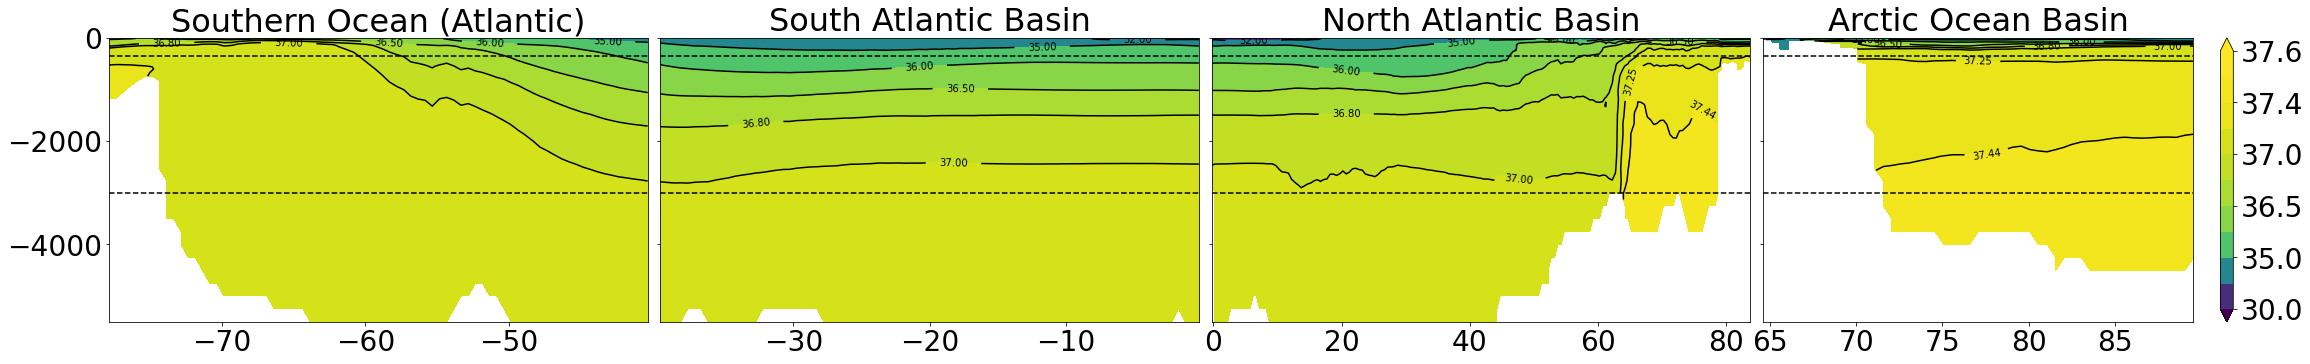

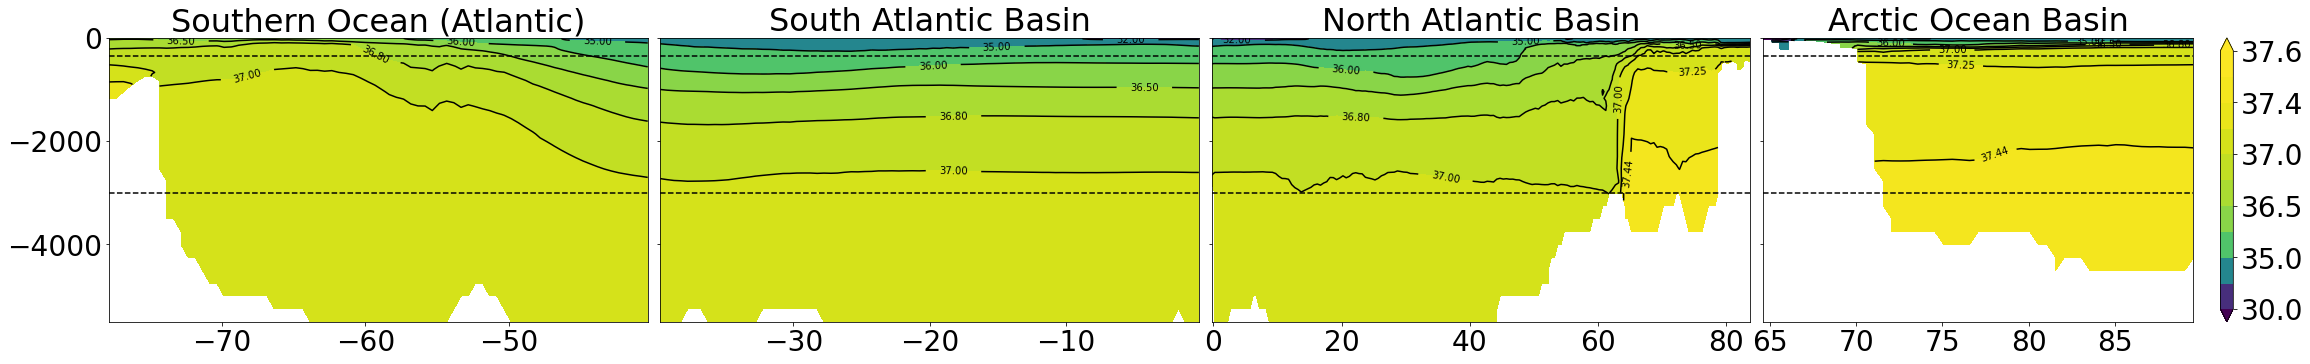

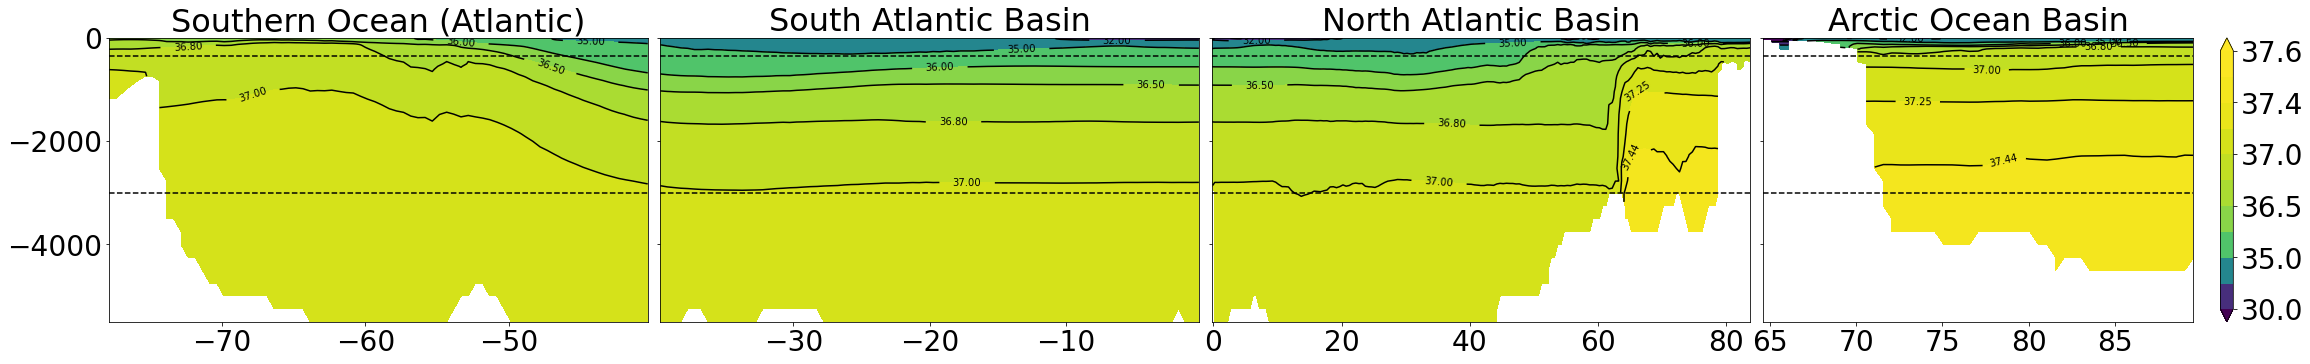

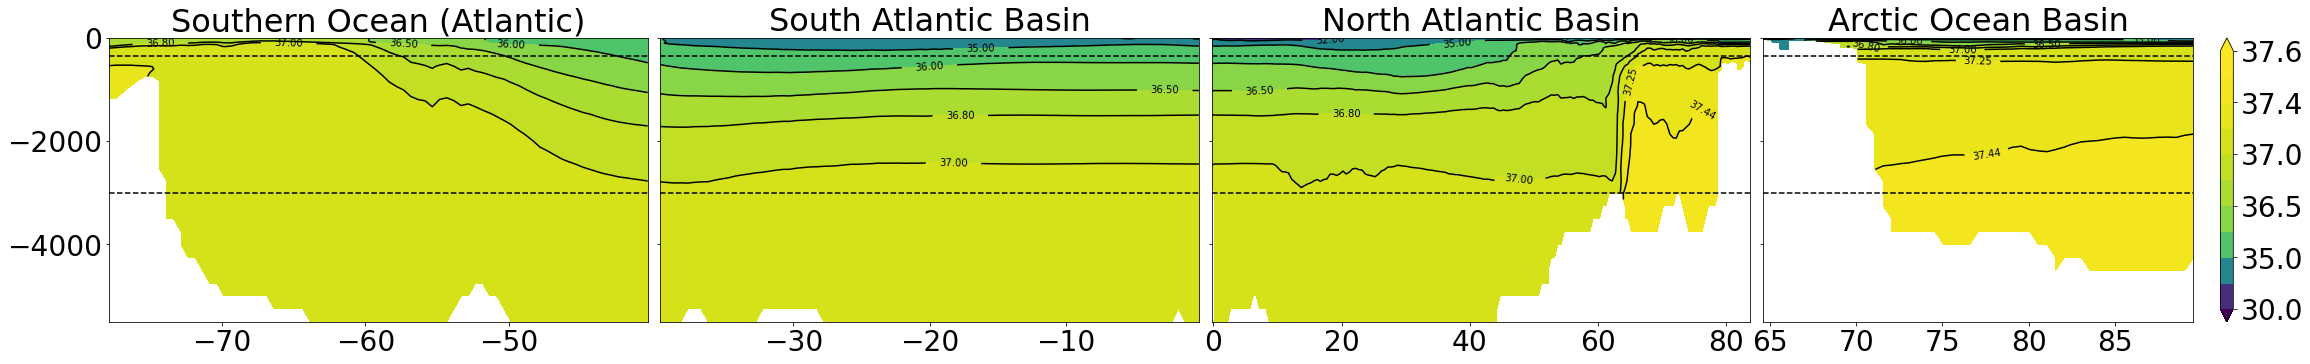

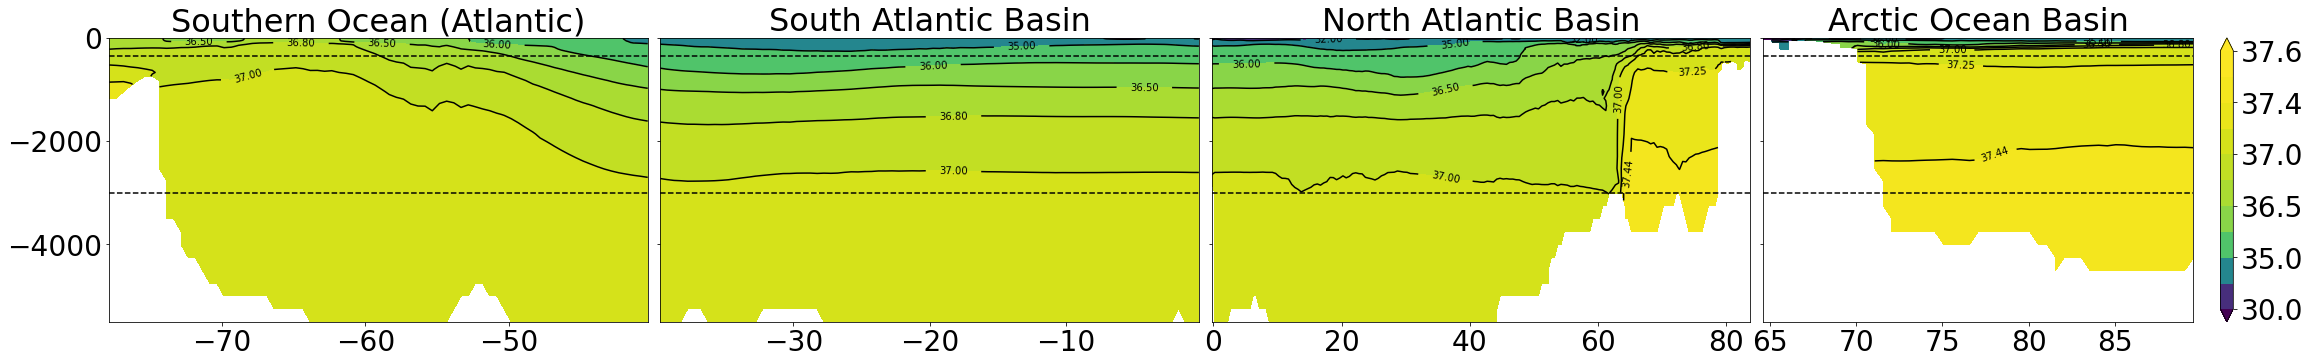

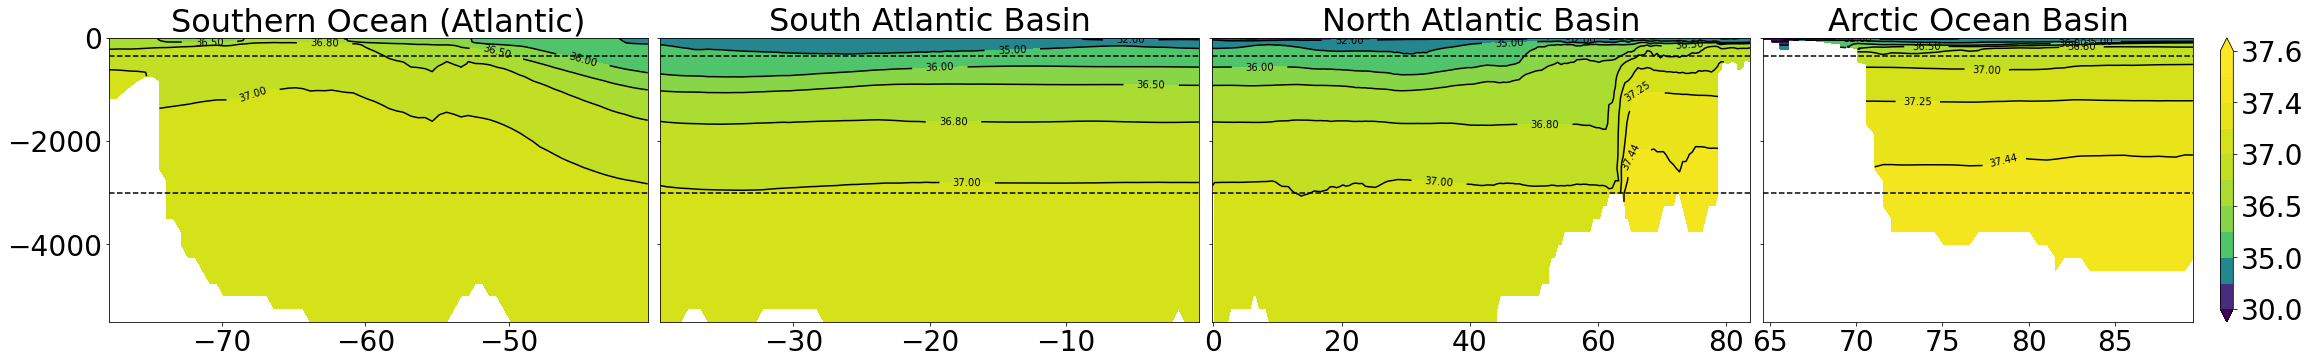

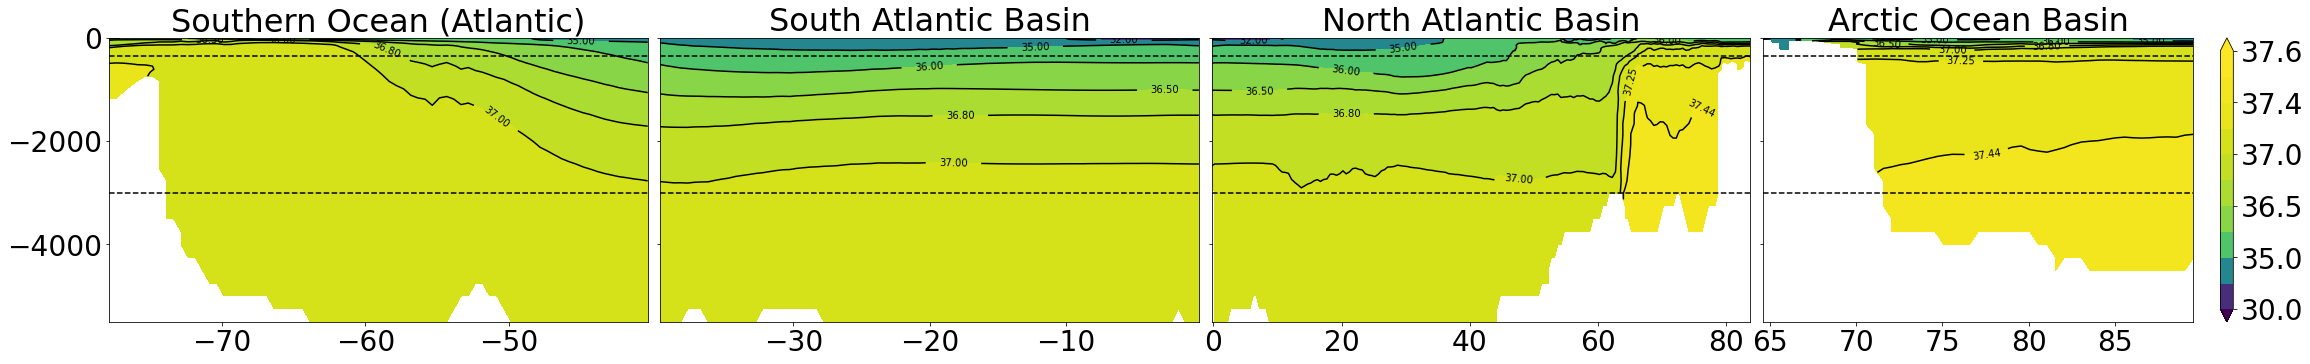

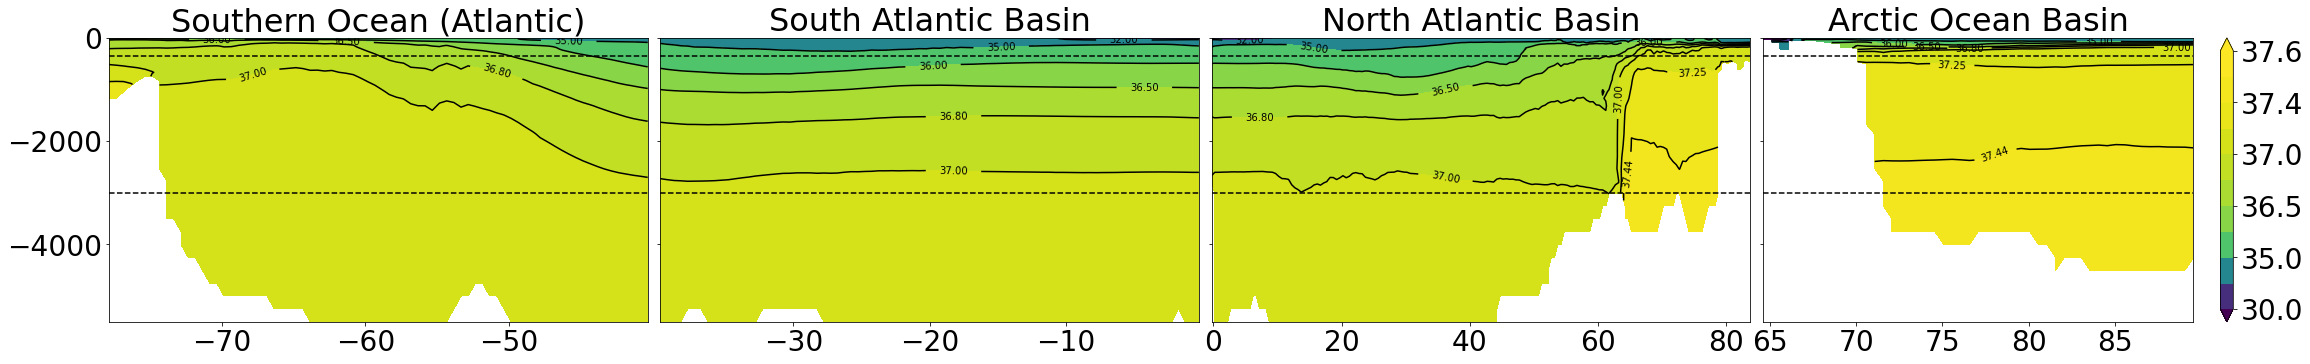

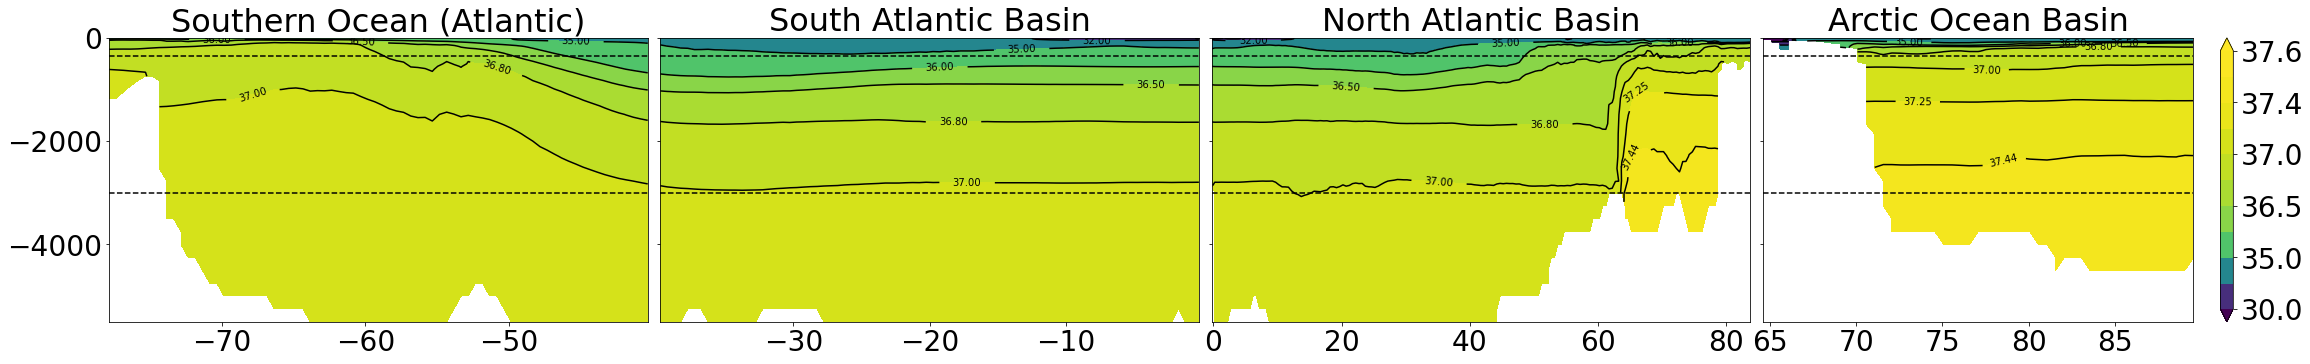

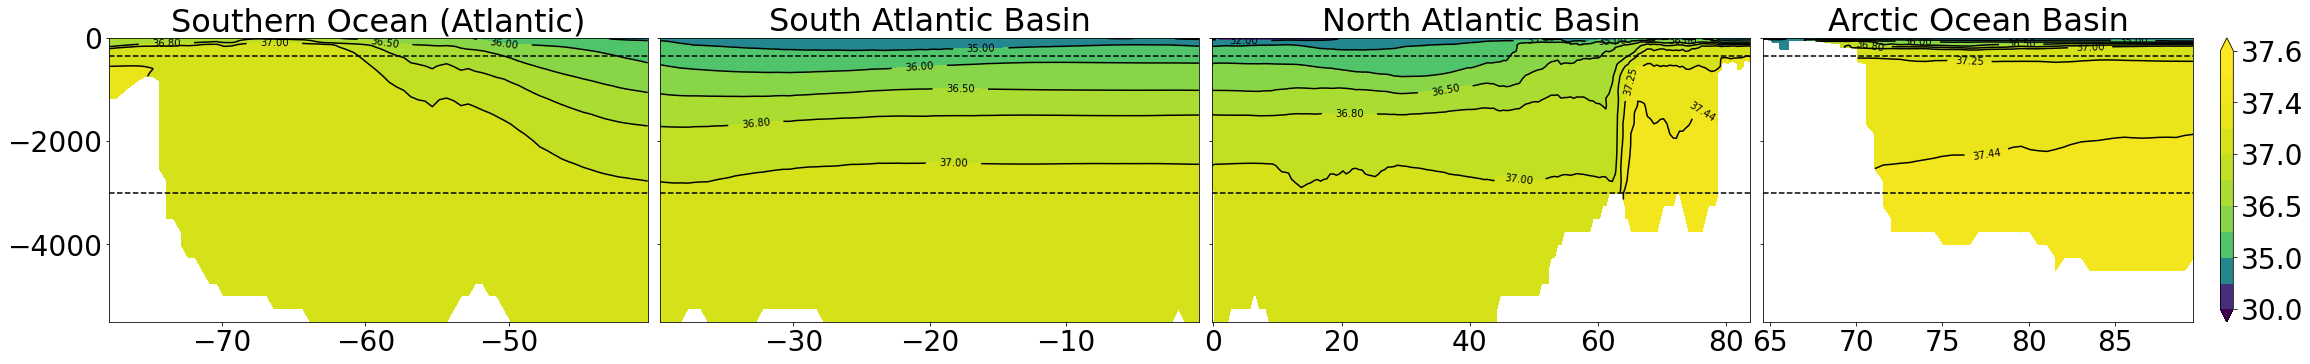

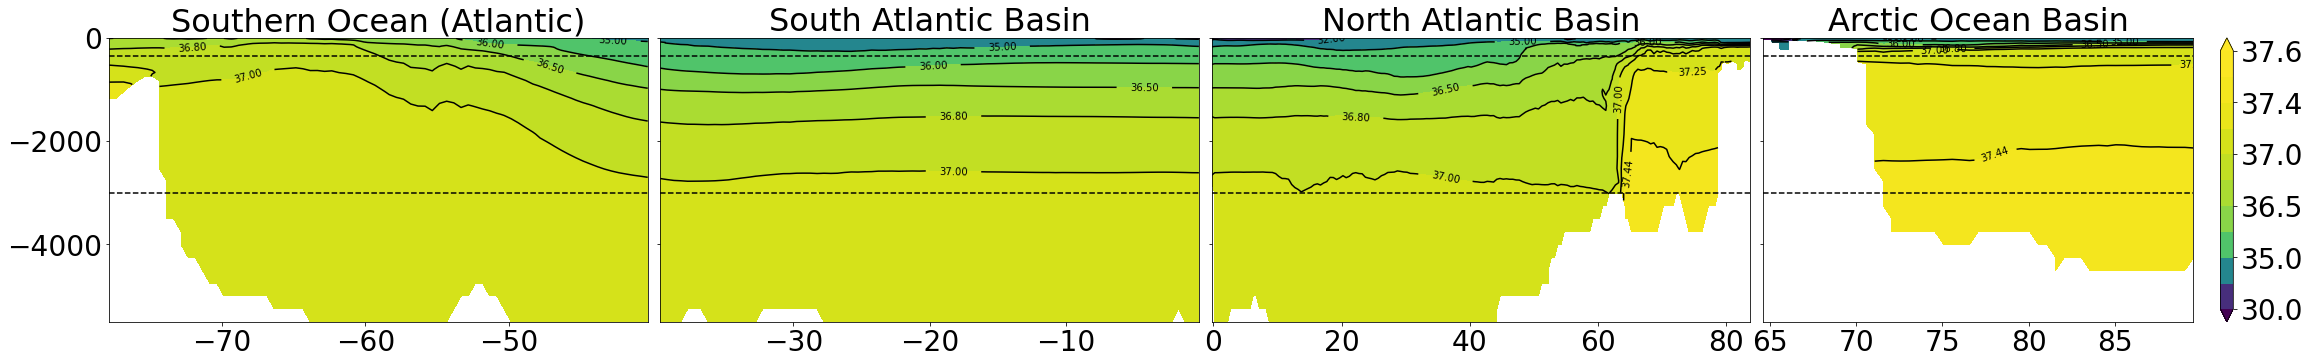

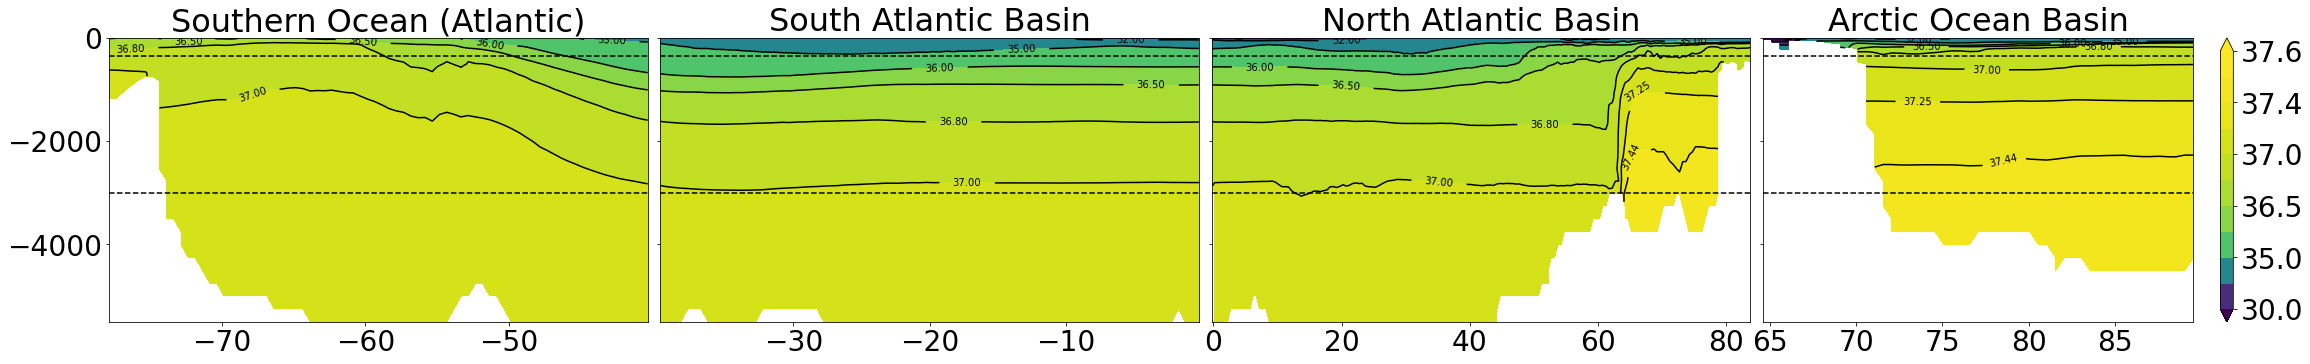

In [46]:
for clim in climlist:
    if clim[10:15] == '_0001':
        continue
    print('working on clim: ', clim)
    flist = '%s/mpaso_%s_climo.nc'%(path, clim)
    dsv2 = xarray.open_dataset(flist)
    sigma2=calculate_sigma2(dsv2,mev2,dist1,indsv2,maskv2)
    namebase = './%s/%s_Sigma2_%s'%(run, run, clim)
    reg= reg = [0, 3,4,5]
    fig, ax= plt.subplots(1,4, figsize=(32,5))
    for ii in np.arange(0,4):
        sp= reg[ii]

        CF=ax[ii].contourf(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2[sp]).T,Cessival,extend='both',cmap='viridis')
        #plt.colorbar()
        CS=ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2[sp]).T,Cessival,colors='k')
        ax[ii].axhline(-350,0, 1, linestyle='--', c='k')
        ax[ii].axhline(-3000,0, 1, linestyle='--', c='k')
        #ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(potdv2[sp]).T,np.linspace(1026.,1030.,11),colors='k',linestyles='dashed')
        plt.clabel(CS,fmt='%1.2f')
        ax[ii].set_title(label[sp],fontsize=32)
        ax[ii].set_ylim(-5500,0)
        #if sp == 6: 
        #    ax[ii].set_ylim(-400,0)
        if Lon:
            plt.xlim(300,360)
    for ax1 in ax.flat:
        ax1.label_outer()
    #ax[-1].yaxis.set_label_position("right")
    #ax[-1].yaxis.tick_right()
    fig.tight_layout(pad=0.5)
    plt.colorbar(CF,format='%1.1f')
    plt.savefig(namebase +'_deep4_Atlantic.png')

/share/apps/E3SM/conda_envs/base/envs/e3sm_unified_1.4.0/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


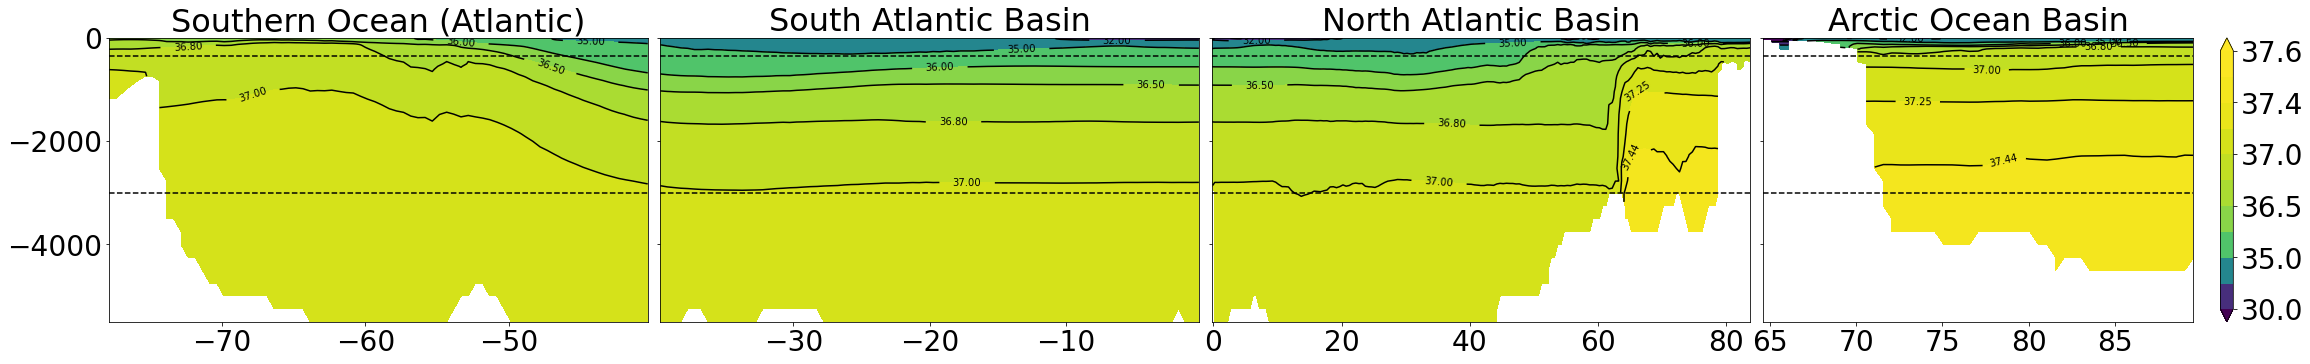

In [22]:
clim = 'ANN_011101_013012'
flist = '%s/mpaso_%s_climo.nc'%(path, clim)
dsv2 = xarray.open_dataset(flist)
sigma2=calculate_sigma2(dsv2,mev2,dist1,indsv2,maskv2)
namebase = './%s/%s_Sigma2_%s'%(run, run, clim)
reg= reg = [0, 3,4,5]
fig, ax= plt.subplots(1,4, figsize=(32,5))
for ii in np.arange(0,4):
    sp= reg[ii]

    CF=ax[ii].contourf(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2[sp]).T,Cessival,extend='both',cmap='viridis')
    #plt.colorbar()
    CS=ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(sigma2[sp]).T,Cessival,colors='k')
    ax[ii].axhline(-350,0, 1, linestyle='--', c='k')
    ax[ii].axhline(-3000,0, 1, linestyle='--', c='k')
    #ax[ii].contour(latsv2[sp]*180./np.pi,-mev2.refBottomDepth.values,(potdv2[sp]).T,np.linspace(1026.,1030.,11),colors='k',linestyles='dashed')
    plt.clabel(CS,fmt='%1.2f')
    ax[ii].set_title(label[sp],fontsize=32)
    ax[ii].set_ylim(-5500,0)
    #if sp == 6: 
    #    ax[ii].set_ylim(-400,0)
    if Lon:
        plt.xlim(300,360)
for ax1 in ax.flat:
    ax1.label_outer()
#ax[-1].yaxis.set_label_position("right")
#ax[-1].yaxis.tick_right()
fig.tight_layout(pad=0.5)
plt.colorbar(CF,format='%1.1f')
plt.savefig(namebase +'deep4_Atlantic.png')